In [35]:
from pathlib import Path

import autochem as ac
import automech
import automol
import more_itertools as mit
import numpy as np
from project_utilities import p_
from protomech import mess

T_range = (300, 1200)
T_vals = (600, 700, 800, 900, 1000, 1100, 1200)
P_vals = (0.1, 1, 10, 100)
T_drop = (300, 400)  # Drop low-T rates for fit
A_fill = 1e-20
compare = False

stoich = "C5H7"
clear_nodes = []
clear_edges = []

stoich = "C5H7O2"
clear_nodes = []  # was clearing: ["C5H6O(645)z+OH(4)", "CPND2(626)+OH(4)"]
clear_edges = []

# stoich = "C5H9"
# clear_nodes = []
# clear_edges = []

# stoich = "C5H9O"
# clear_nodes = []
# clear_edges = []

# stoich = "C5H9O2"
# clear_nodes = []
# clear_edges = [
#     # Well-skipping:
#     ("C5H8O(833)+OH(4)", "C5H8O(829)rs+OH(4)")
# ]

# stoich = "C5H11O"  # suspicious -- doesn't seem to compare well with theory
# clear_nodes = []
# clear_edges = []

# stoich = "C5H11O2"
# clear_nodes = []
# clear_edges = []

tag = "Z_mess_v0"
root_path = Path("../..")
stoich_path = Path(stoich)

In [36]:
mech = automech.io.read(p_.stereo_mechanism(tag, "json", p_.data(root_path)))
mech.reactions = automech.reaction.select_pes(mech.reactions, stoich)
mech = automech.without_unused_species(mech)

In [37]:
mess_inp = stoich_path / "mess.inp"
surf = mess.surf.from_mess_input(mess_inp)

In [38]:
mess_out = stoich_path / "rate.out"
surf_out = mess.surf.with_mess_output_rates(surf, mess_out=mess_out)
surf_out = mess.surf.absorb_fake_nodes(surf_out)
surf_out = mess.surf.enforce_equal_enantiomer_rates(surf_out, tol=0.1)
mess.net.display(surf_out, mech=mech, height="1000px")

In [39]:
clear_node_keys = [
    mess.surf.node_key_from_label(surf_out, label) for label in clear_nodes
]
clear_edge_keys = [
    mess.surf.edge_key_from_labels(surf_out, labels) for labels in clear_edges
]

print(f"Clearing out rates for nodes {clear_node_keys}")
surf_out = mess.surf.clear_node_rates(surf_out, keys=clear_node_keys)

print(f"Clearing out rates for edges {clear_edge_keys}")
surf_out = mess.surf.clear_edge_rates(surf_out, keys=clear_edge_keys)

Clearing out rates for nodes []
Clearing out rates for edges []


In [40]:
print("Clearing unfittable pressure ranges.")
surf_out = mess.surf.clear_unfittable_pressure_ranges(surf_out)

Clearing unfittable pressure ranges.


In [41]:
unfit_skip_rate_keys = mess.surf.unfittable_rate_keys(surf_out, direct=False)
print(f"Dropping completely unfittable well-skipping rates:\n{unfit_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, unfit_skip_rate_keys)

Dropping completely unfittable well-skipping rates:
[(2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 1), (2, 20), (2, 24), (2, 27), (3, 4), (3, 7), (3, 8), (3, 9), (3, 11), (3, 20), (4, 3), (4, 6), (4, 7), (4, 8), (4, 9), (4, 11), (4, 1), (4, 20), (4, 24), (4, 27), (5, 2), (5, 7), (5, 8), (5, 9), (5, 11), (5, 20), (6, 4), (6, 11), (6, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 10), (7, 11), (7, 1), (7, 20), (7, 24), (8, 2), (8, 3), (8, 4), (8, 5), (8, 1), (8, 20), (9, 2), (9, 3), (9, 4), (9, 5), (9, 20), (10, 2), (10, 7), (10, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 1), (11, 20), (11, 24), (12, 20), (1, 2), (1, 4), (1, 6), (1, 7), (1, 8), (1, 10), (1, 11), (1, 20), (1, 24), (20, 2), (20, 3), (20, 4), (20, 5), (20, 7), (20, 8), (20, 9), (20, 11), (20, 12), (20, 1), (20, 22), (20, 23), (20, 24), (20, 25), (22, 20), (23, 20), (24, 2), (24, 4), (24, 7), (24, 11), (24, 1), (24, 20), (25, 20), (27, 2), (27, 3), (27, 4), (27, 5), (27, 6), (27, 10), (27, 12), (27, 1),

In [42]:
surf_out = mess.surf.remove_isolates(surf_out)
irrel_skip_rate_keys = mess.surf.irrelevant_rate_keys(
    surf_out, T=T_vals, P=P_vals, direct=False, min_branch_frac=0.01
)
print(f"Dropping irrelevant well-skipping rates:\n{irrel_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, irrel_skip_rate_keys)

Dropping irrelevant well-skipping rates:
[(1, 9), (1, 12), (1, 26), (2, 12), (2, 22), (2, 23), (2, 26), (3, 5), (3, 10), (3, 23), (3, 25), (3, 26), (4, 12), (4, 22), (4, 23), (4, 26), (5, 3), (5, 6), (5, 22), (5, 25), (5, 26), (6, 5), (6, 10), (6, 12), (6, 23), (6, 24), (6, 25), (6, 26), (7, 8), (7, 9), (7, 12), (7, 23), (7, 25), (7, 26), (8, 7), (8, 9), (8, 11), (8, 12), (8, 24), (8, 25), (8, 26), (9, 7), (9, 8), (9, 11), (9, 12), (9, 1), (9, 24), (9, 26), (10, 3), (10, 6), (10, 12), (10, 22), (10, 24), (10, 25), (10, 26), (11, 8), (11, 9), (11, 12), (11, 22), (11, 25), (11, 26), (12, 2), (12, 4), (12, 6), (12, 7), (12, 8), (12, 9), (12, 10), (12, 11), (12, 1), (12, 24), (12, 25), (20, 26), (21, 7), (21, 8), (21, 9), (21, 11), (21, 1), (21, 20), (21, 24), (21, 26), (22, 2), (22, 4), (22, 5), (22, 7), (22, 8), (22, 9), (22, 10), (22, 11), (22, 12), (22, 1), (22, 23), (22, 24), (22, 25), (22, 26), (23, 2), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 9), (23, 11), (23, 12), (23, 1)

In [43]:
punfit_skip_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, direct=False
)
print(
    f"Dropping partially-unfittable pressure-independent well-skipping rates:\n{punfit_skip_rate_keys}"
)

surf_out = mess.surf.remove_well_skipping_rates(surf_out, punfit_skip_rate_keys)

Dropping partially-unfittable pressure-independent well-skipping rates:
[]


In [44]:
unfit_rate_keys = mess.surf.unfittable_rate_keys(surf_out, well_skipping=False)
print(f"Clearing completely unfittable direct rates:\n{unfit_rate_keys}")

surf_out = mess.surf.clear_rates(surf_out, unfit_rate_keys)

Clearing completely unfittable direct rates:
[(6, 20), (10, 20), (20, 6), (20, 10), (27, 7), (27, 8), (27, 9), (27, 11)]


In [45]:
punfit_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, well_skipping=False, empty=False
)
print(
    f"Clearing partially-unfittable pressure-independent direct rates:\n{punfit_rate_keys}"
)

surf_out = mess.surf.clear_rates(surf_out, punfit_rate_keys)

Clearing partially-unfittable pressure-independent direct rates:
[(2, 6), (3, 6), (3, 1), (4, 10), (5, 10), (5, 1), (6, 2), (6, 3), (6, 7), (6, 8), (6, 9), (7, 6), (8, 6), (8, 10), (9, 6), (9, 10), (10, 4), (10, 5), (10, 8), (10, 9), (10, 11), (11, 10), (1, 3), (1, 5)]


In [46]:
# Identifying branching fractions as well as 
print("Calculating branching fractions.")
branch_frac_dct = mess.surf.branching_fractions(surf_out, T=T_vals, P=P_vals)

print("Determining irrelevant pressures.")
irrel_pressure_dct = mess.surf.irrelevant_rate_pressures(
    surf_out, T=T_vals, P=P_vals, min_branch_frac=0.01
)
print(irrel_pressure_dct)

Calculating branching fractions.
Determining irrelevant pressures.


/home/avcopan/proj/project-cyclopentane/code/protomech/src/protomech/mess/surf.py:1728: RuntimeWarning: invalid value encountered in divide
  z = np.abs((branch_frac - branch_frac.mean()) / branch_frac.std())


{(1, 3): [0.1, 1.0, 10.0, 100.0], (1, 5): [0.1, 1.0, 10.0, 100.0], (2, 3): [0.1, 1.0, 10.0, 100.0], (2, 4): [], (2, 6): [0.1, 1.0, 10.0, 100.0], (2, 21): [0.1, 1.0, 10.0, 100.0], (2, 25): [], (3, 2): [0.1, 1.0, 10.0, 100.0], (3, 6): [0.1, 1.0, 10.0, 100.0], (3, 12): [0.1, 1.0, 10.0, 100.0], (3, 1): [0.1, 1.0, 10.0, 100.0], (3, 21): [], (3, 22): [], (3, 24): [0.1, 1.0, 10.0, 100.0], (4, 2): [], (4, 5): [0.1, 1.0, 10.0, 100.0], (4, 10): [0.1, 1.0, 10.0, 100.0], (4, 21): [0.1, 1.0, 10.0, 100.0], (4, 25): [], (5, 4): [0.1, 1.0, 10.0, 100.0], (5, 10): [0.1, 1.0, 10.0, 100.0], (5, 12): [0.1, 1.0, 10.0, 100.0], (5, 1): [0.1, 1.0, 10.0, 100.0], (5, 21): [], (5, 23): [], (5, 24): [0.1, 1.0, 10.0, 100.0], (6, 2): [0.1, 1.0, 10.0, 100.0], (6, 3): [0.1, 1.0, 10.0, 100.0], (6, 7): [0.1, 1.0, 10.0, 100.0], (6, 8): [0.1, 1.0, 10.0, 100.0], (6, 9): [0.1, 1.0, 10.0, 100.0], (6, 20): [0.1, 1.0, 10.0, 100.0], (6, 21): [], (6, 22): [], (7, 6): [0.1, 1.0, 10.0, 100.0], (7, 27): [], (8, 6): [0.1, 1.0, 10.0,

In [47]:
print("Matching rates to reaction directions.")
surf_out = mess.surf.match_rate_directions(surf_out, mech)

Matching rates to reaction directions.


In [48]:
surf_out = mess.surf.fit_rates(
    surf_out,
    T_drop=T_drop,
    A_fill=A_fill,
    bad_fit="raise",
    bad_fit_fill_pressures_dct=irrel_pressure_dct,
)

/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=0.00043547551919636066 b=4.322117207409702 E=20136.364044227055 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=2417591604.8200517 b=1.3841243180707474 E=22925.578918411695 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=6202636768.677254 b=1.197391071898203 E=25460.927914690477 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: 

Direct rates:
(2, 3) S(1206)r0 = S(1210)r0


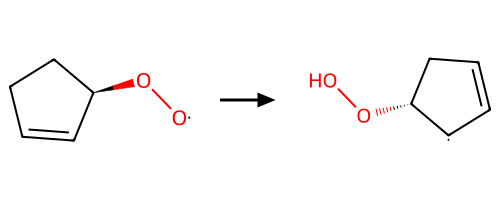

alt.LayerChart(...)

Median branching fraction: 2.3556308136920073e-07
[[           nan            nan 8.57053310e-08 1.67046299e-07]
 [           nan 7.99167093e-08 1.22040217e-07 3.13674403e-07]
 [           nan 5.58671621e-08 1.63379252e-07 5.06002946e-07]
 [           nan 6.27968384e-08 2.06280086e-07 7.98735164e-07]
 [           nan 9.14577691e-08 2.64846077e-07 7.89300849e-07]
 [           nan 1.73085942e-07 3.89814351e-07 1.24648499e-06]
 [           nan 3.46039656e-07 6.69641819e-07 1.66784650e-06]]

(2, 21) S(1206)r0 = C5H6(478) + HO2(8)


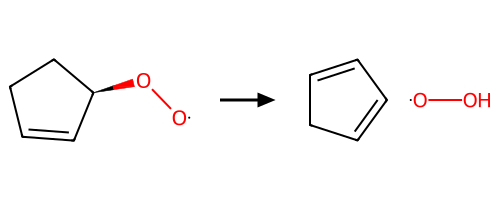

alt.LayerChart(...)

Median branching fraction: 1.0343140718431762e-05
[[2.39995130e-07 1.32694877e-06 4.78102639e-06 1.03431407e-05]
 [4.38009393e-07 2.13644003e-06 7.86959589e-06 1.96833603e-05]
 [7.20687244e-07 3.13617933e-06 1.14288773e-05 3.09944824e-05]
 [9.95809900e-07 4.30187687e-06 1.53541811e-05 4.35673726e-05]
 [2.21511270e-06 6.56135737e-06 2.01551754e-05 5.73159785e-05]
 [5.96796208e-06 1.29081042e-05 2.87862906e-05 7.31581842e-05]
 [1.31381144e-05 2.45141524e-05 4.48942966e-05            nan]]

(3, 21) S(1210)r0 = C5H6(478) + HO2(8)


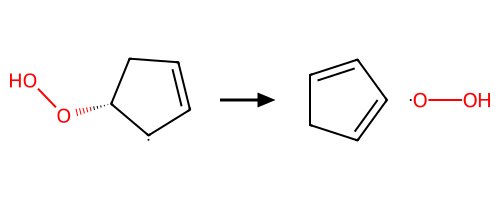

alt.LayerChart(...)

Median branching fraction: 0.2950675085357778
[[0.12193252 0.15944994 0.17519425 0.17843459]
 [0.15438324 0.21356181 0.24889607 0.25870694]
 [0.18132201 0.25524772 0.30984198 0.33077572]
 [0.20411392 0.28819195 0.35616954 0.39226974]
 [0.22698066 0.31381619 0.39252627 0.44075837]
 [0.25874844 0.33983029 0.42156661 0.47830478]
 [0.30194307 0.36734835 0.44516256 0.50695121]]

(3, 22) S(1210)r0 = OH(4) + S(1288)rs0


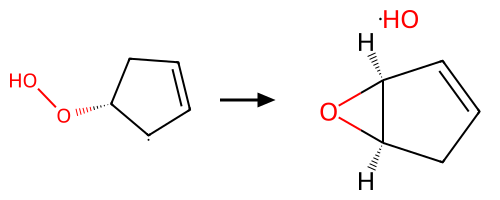

alt.LayerChart(...)

Median branching fraction: 0.7048257281974093
[[0.87806748 0.84043893 0.82468015 0.82142795]
 [0.84561676 0.78631005 0.75094283 0.74110784]
 [0.81867799 0.74461922 0.68996624 0.66898459]
 [0.79588608 0.71168161 0.64362921 0.60744253]
 [0.77291555 0.68606712 0.60728031 0.55893272]
 [0.74116078 0.66005499 0.57825508 0.52138191]
 [0.69796985 0.63252551 0.55466779 0.49275323]]

(3, 24) S(1210)r0 = C5Oqidgnvrs + OH(4)


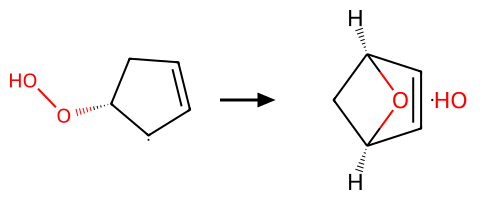

alt.LayerChart(...)

Median branching fraction: 5.636898947297655e-09
[[           nan            nan            nan            nan]
 [           nan            nan            nan            nan]
 [           nan            nan 7.73533582e-10 3.68279398e-09]
 [           nan 8.72005487e-11 2.84655185e-09 1.86394537e-08]
 [           nan 2.35903207e-10 7.59100391e-09 6.19616840e-08]
 [           nan 5.56798864e-10 1.63776761e-08 1.54483530e-07]
 [           nan 1.22449451e-09 3.07090748e-08 3.14860965e-07]]

(4, 5) S(1206)r1 = S(1210)r1


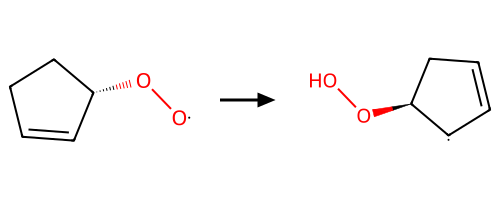

alt.LayerChart(...)

Median branching fraction: 2.3556308136920073e-07
[[           nan            nan 8.57053310e-08 1.67046299e-07]
 [           nan 7.99167093e-08 1.22040217e-07 3.13674403e-07]
 [           nan 5.58671621e-08 1.63379252e-07 5.06002946e-07]
 [           nan 6.27968384e-08 2.06280086e-07 7.98735164e-07]
 [           nan 9.14577691e-08 2.64846077e-07 7.89300849e-07]
 [           nan 1.73085942e-07 3.89814351e-07 1.24648499e-06]
 [           nan 3.46039656e-07 6.69641819e-07 1.66784650e-06]]

(4, 21) S(1206)r1 = C5H6(478) + HO2(8)


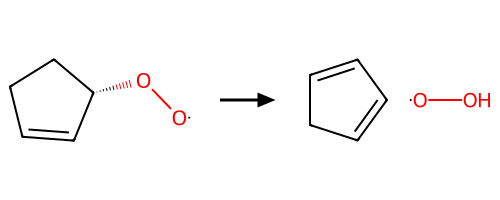

alt.LayerChart(...)

Median branching fraction: 1.0343140718431762e-05
[[2.39995130e-07 1.32694877e-06 4.78102639e-06 1.03431407e-05]
 [4.38009393e-07 2.13644003e-06 7.86959589e-06 1.96833603e-05]
 [7.20687244e-07 3.13617933e-06 1.14288773e-05 3.09944824e-05]
 [9.95809900e-07 4.30187687e-06 1.53541811e-05 4.35673726e-05]
 [2.21511270e-06 6.56135737e-06 2.01551754e-05 5.73159785e-05]
 [5.96796208e-06 1.29081042e-05 2.87862906e-05 7.31581842e-05]
 [1.31381144e-05 2.45141524e-05 4.48942966e-05            nan]]

(5, 21) S(1210)r1 = C5H6(478) + HO2(8)


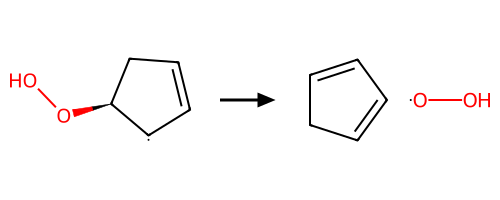

alt.LayerChart(...)

Median branching fraction: 0.2950675085357778
[[0.12193252 0.15944994 0.17519425 0.17843459]
 [0.15438324 0.21356181 0.24889607 0.25870694]
 [0.18132201 0.25524772 0.30984198 0.33077572]
 [0.20411392 0.28819195 0.35616954 0.39226974]
 [0.22698066 0.31381619 0.39252627 0.44075837]
 [0.25874844 0.33983029 0.42156661 0.47830478]
 [0.30194307 0.36734835 0.44516256 0.50695121]]

(5, 23) S(1210)r1 = OH(4) + S(1288)rs1


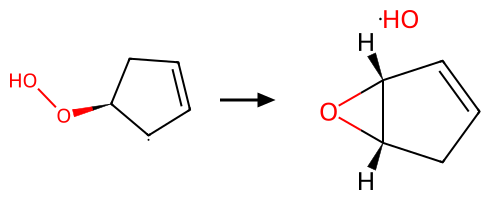

alt.LayerChart(...)

Median branching fraction: 0.7048257281974093
[[0.87806748 0.84043893 0.82468015 0.82142795]
 [0.84561676 0.78631005 0.75094283 0.74110784]
 [0.81867799 0.74461922 0.68996624 0.66898459]
 [0.79588608 0.71168161 0.64362921 0.60744253]
 [0.77291555 0.68606712 0.60728031 0.55893272]
 [0.74116078 0.66005499 0.57825508 0.52138191]
 [0.69796985 0.63252551 0.55466779 0.49275323]]

(5, 24) S(1210)r1 = C5Oqidgnvrs + OH(4)


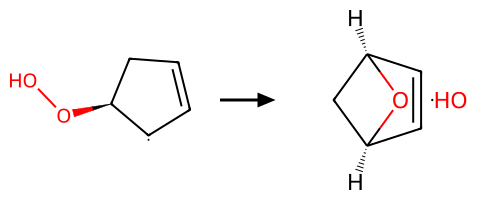

alt.LayerChart(...)

Median branching fraction: 5.636898947297655e-09
[[           nan            nan            nan            nan]
 [           nan            nan            nan            nan]
 [           nan            nan 7.73533582e-10 3.68279398e-09]
 [           nan 8.72005487e-11 2.84655185e-09 1.86394537e-08]
 [           nan 2.35903207e-10 7.59100391e-09 6.19616840e-08]
 [           nan 5.56798864e-10 1.63776761e-08 1.54483530e-07]
 [           nan 1.22449451e-09 3.07090748e-08 3.14860965e-07]]

(6, 21) S(1209)r0 = C5H6(478) + HO2(8)


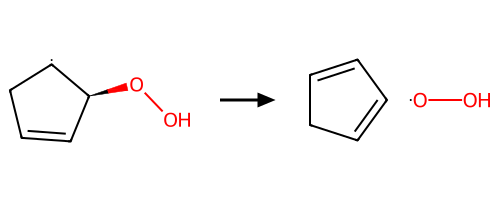

alt.LayerChart(...)

Median branching fraction: 0.8200330214639515
[[       nan 0.82526745 0.82228713 0.82184874]
 [0.82807018 0.82248521 0.82066869 0.81978095]
 [0.82533589 0.82071713 0.81958345 0.81927711]
 [0.82158921 0.81991952 0.81886228 0.82051282]
 [0.81967213 0.8190091  0.81964286 0.82065055]
 [0.81895093 0.81942544 0.82003302 0.82092476]
 [0.81884058 0.81954887 0.82       0.82180851]]

(6, 22) S(1209)r0 = OH(4) + S(1288)rs0


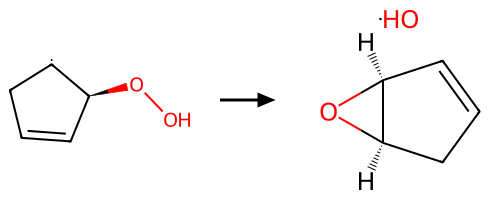

alt.LayerChart(...)

Median branching fraction: 0.17996697853604843
[[       nan 0.17473255 0.17771287 0.17815126]
 [0.17192982 0.17751479 0.17933131 0.18021905]
 [0.17466411 0.17928287 0.18041655 0.18072289]
 [0.17841079 0.18008048 0.18113772 0.17948718]
 [0.18032787 0.1809909  0.18035714 0.17934945]
 [0.18104907 0.18057456 0.17996698 0.17907524]
 [0.18115942 0.18045113 0.18       0.17819149]]

(7, 27) C5O2pkpfsder0 = C2H2(40) + C3H4O(165) + OH(4)


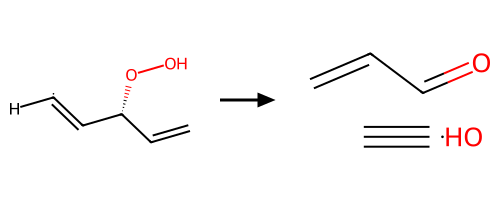

alt.LayerChart(...)

Median branching fraction: 1.0
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

(8, 27) C5O2sidwaoee = C2H2(40) + C3H4O(165) + OH(4)


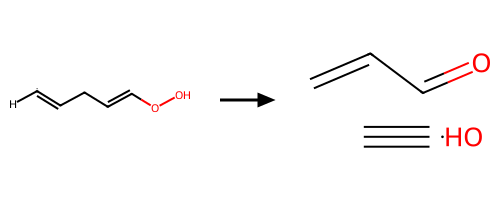

alt.LayerChart(...)

Median branching fraction: 1.0
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

(9, 27) C5O2sidwaoez = C2H2(40) + C3H4O(165) + OH(4)


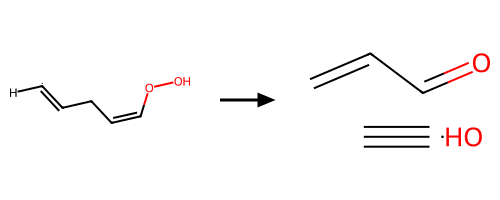

alt.LayerChart(...)

Median branching fraction: 1.0
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

(10, 21) S(1209)r1 = C5H6(478) + HO2(8)


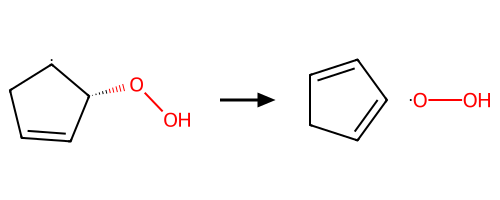

alt.LayerChart(...)

Median branching fraction: 0.8200330214639515
[[       nan 0.82526745 0.82228713 0.82184874]
 [0.82807018 0.82248521 0.82066869 0.81978095]
 [0.82533589 0.82071713 0.81958345 0.81927711]
 [0.82158921 0.81991952 0.81886228 0.82051282]
 [0.81967213 0.8190091  0.81964286 0.82065055]
 [0.81895093 0.81942544 0.82003302 0.82092476]
 [0.81884058 0.81954887 0.82       0.82180851]]

(10, 23) S(1209)r1 = OH(4) + S(1288)rs1


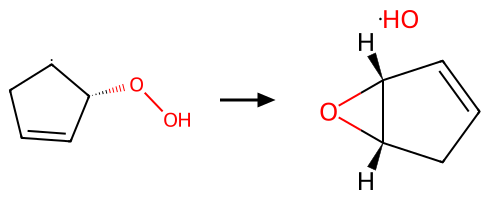

alt.LayerChart(...)

Median branching fraction: 0.17996697853604843
[[       nan 0.17473255 0.17771287 0.17815126]
 [0.17192982 0.17751479 0.17933131 0.18021905]
 [0.17466411 0.17928287 0.18041655 0.18072289]
 [0.17841079 0.18008048 0.18113772 0.17948718]
 [0.18032787 0.1809909  0.18035714 0.17934945]
 [0.18104907 0.18057456 0.17996698 0.17907524]
 [0.18115942 0.18045113 0.18       0.17819149]]

(11, 27) C5O2pkpfsder1 = C2H2(40) + C3H4O(165) + OH(4)


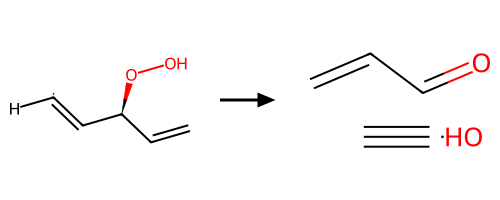

alt.LayerChart(...)

Median branching fraction: 1.0
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

(12, 3) S(602) = S(1210)r0


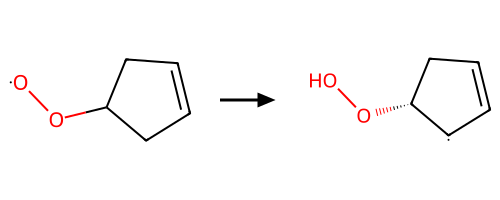

alt.LayerChart(...)

Median branching fraction: 0.008797968506845378
[[       nan 0.04391136 0.04804333 0.04903961]
 [       nan 0.01826383 0.02339421 0.02529873]
 [       nan 0.00927467 0.01407699 0.01700329]
 [       nan 0.00556128 0.0092567  0.01292203]
 [0.00487893 0.00423595 0.00659229 0.01027729]
 [0.00521358 0.00410732 0.00523273 0.00833924]
 [0.00618801 0.00500293 0.00479546 0.00703817]]

(12, 5) S(602) = S(1210)r1


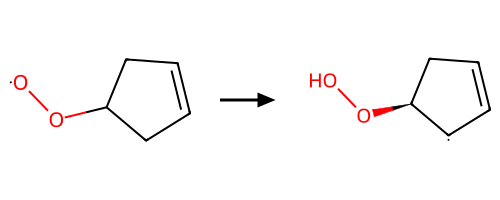

alt.LayerChart(...)

Median branching fraction: 0.008797968506845378
[[       nan 0.04391136 0.04804333 0.04903961]
 [       nan 0.01826383 0.02339421 0.02529873]
 [       nan 0.00927467 0.01407699 0.01700329]
 [       nan 0.00556128 0.0092567  0.01292203]
 [0.00487893 0.00423595 0.00659229 0.01027729]
 [0.00521358 0.00410732 0.00523273 0.00833924]
 [0.00618801 0.00500293 0.00479546 0.00703817]]

(12, 21) S(602) = C5H6(478) + HO2(8)


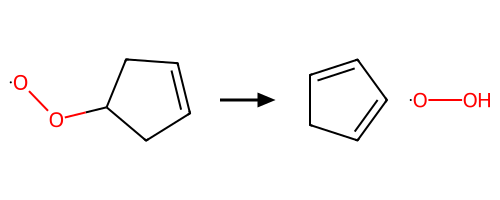

alt.LayerChart(...)

Median branching fraction: 0.07079827621588344
[[       nan 0.094938   0.08455625 0.08261091]
 [0.11060059 0.08355516 0.07079828 0.06721434]
 [0.09967846 0.07776457 0.06484446 0.05936633]
 [0.09231963 0.0736594  0.06272451 0.056126  ]
 [0.08673654 0.07098268 0.06186613 0.0554586 ]
 [0.08172632 0.0685809  0.06143158 0.05602421]
 [0.07617729 0.06602966 0.06067724 0.05717603]]

(25, 2) C5H7(500) + O2(6) = S(1206)r0


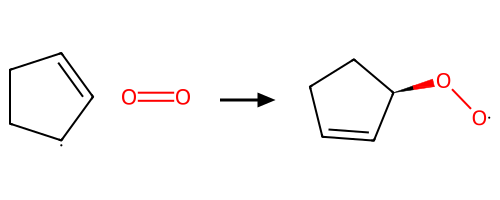

alt.LayerChart(...)

Median branching fraction: 0.4984673294263433
[[0.4997663  0.49995159 0.49998645 0.49999628]
 [0.49812174 0.49967834 0.49992902 0.49998154]
 [0.49128368 0.49846733 0.49969698 0.49992873]
 [0.48291443 0.49568504 0.49902153 0.49977489]
 [0.47684235 0.49258204 0.49776559 0.49941956]
 [0.47099473 0.48982716 0.49628953 0.49880922]
 [       nan 0.48625181 0.4945347  0.49793572]]

(25, 4) C5H7(500) + O2(6) = S(1206)r1


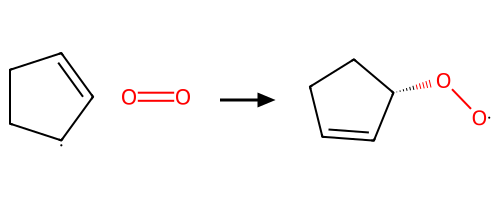

alt.LayerChart(...)

Median branching fraction: 0.4984673294263433
[[0.4997663  0.49995159 0.49998645 0.49999628]
 [0.49812174 0.49967834 0.49992902 0.49998154]
 [0.49128368 0.49846733 0.49969698 0.49992873]
 [0.48291443 0.49568504 0.49902153 0.49977489]
 [0.47684235 0.49258204 0.49776559 0.49941956]
 [0.47099473 0.48982716 0.49628953 0.49880922]
 [       nan 0.48625181 0.4945347  0.49793572]]

(26, 12) C5H7(504) + O2(6) = S(602)


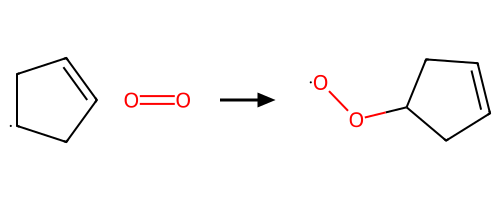

alt.LayerChart(...)

Median branching fraction: 1.0
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]



In [49]:
label_dct = mess.surf.node_label_dict(surf_out)
obj_col = automech.util.df_.c_.temp()

print("Direct rates:")
for rate_key in mess.surf.rate_keys(
    surf_out, P_vals=[1.0], empty=False, well_skipping=False
):
    eq = mess.surf.edge_chemkin_equation(surf_out, rate_key)
    print(rate_key, eq)

    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]

    amchis = list(mit.unique_everseen(automech.reaction_amchis(mech, eq=eq)))
    for amchi in amchis:
        automol.amchi.display_reaction(*amchi)

    ref_rates = ref_labels = []
    if compare and amchis:
        ref_rates = [r.rate for r in automech.reaction_rate_objects(mech, eq)]
        ref_labels = [f"Ref {i}" for i, _ in enumerate(ref_rates)]

    display(
        ac.rate.data.display(
            [rate, rate_fit, *ref_rates],
            T_range=T_range,
            label=["Data", "Fit", *ref_labels],
            check_order=False,
        )
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

In [50]:
print("Well-skipping rates:")
for rate_key in mess.surf.rate_keys(surf_out, direct=False):
    print(rate_key)
    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]
    display(
        ac.rate.data.display([rate, rate_fit], T_range=T_range, label=["Data", "Fit"])
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

Well-skipping rates:
(2, 4)


alt.LayerChart(...)

Median branching fraction: 0.010415334912331868
[[0.00553372 0.0089863  0.01390844 0.01906921]
 [0.00417004 0.0063667  0.0101444  0.01581199]
 [0.00493872 0.00581526 0.00795163 0.01246987]
 [0.00897665 0.00815772 0.00797082 0.01040213]
 [0.01042854 0.01106934 0.00990079 0.00993863]
 [0.01109983 0.01232137 0.01220595 0.01089218]
 [0.01155224 0.01266645 0.0134117  0.01236255]]

(22, 21)


alt.LayerChart(...)

Median branching fraction: 0.3357186959712374
[[1.60363193e-01 4.29324811e-02 6.91951442e-03 7.86540671e-04]
 [4.20331582e-01 1.49674431e-01 3.24058892e-02 4.31232751e-03]
 [6.94620015e-01 3.49026234e-01 1.02170016e-01 1.69086318e-02]
 [8.49753972e-01 5.73204271e-01 2.31933765e-01 4.94377328e-02]
 [9.11997796e-01 7.34014789e-01 3.97712839e-01 1.12985099e-01]
 [9.36775313e-01 8.25791575e-01 5.55007582e-01 2.08924902e-01]
 [9.45987611e-01 8.70252639e-01 6.70797366e-01 3.22411158e-01]]

(23, 21)


alt.LayerChart(...)

Median branching fraction: 0.3357186959712374
[[1.60363193e-01 4.29324811e-02 6.91951442e-03 7.86540671e-04]
 [4.20331582e-01 1.49674431e-01 3.24058892e-02 4.31232751e-03]
 [6.94620015e-01 3.49026234e-01 1.02170016e-01 1.69086318e-02]
 [8.49753972e-01 5.73204271e-01 2.31933765e-01 4.94377328e-02]
 [9.11997796e-01 7.34014789e-01 3.97712839e-01 1.12985099e-01]
 [9.36775313e-01 8.25791575e-01 5.55007582e-01 2.08924902e-01]
 [9.45987611e-01 8.70252639e-01 6.70797366e-01 3.22411158e-01]]

(25, 21)


alt.LayerChart(...)

Median branching fraction: 0.003065341147313401
[[4.67407328e-04 9.68136217e-05 2.70928620e-05 7.43050034e-06]
 [3.75652092e-03 6.43310581e-04 1.41960976e-04 3.69161999e-05]
 [1.74326466e-02 3.06534115e-03 6.06035511e-04 1.42532873e-04]
 [3.41711381e-02 8.62991227e-03 1.95694716e-03 4.50210442e-04]
 [4.63153091e-02 1.48359278e-02 4.46882881e-03 1.16087840e-03]
 [5.80105474e-02 2.03456853e-02 7.42093312e-03 2.38156190e-03]
 [           nan 2.74963821e-02 1.09306034e-02 4.12856772e-03]]

